In [28]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

df = pd.read_csv('../datasets/famcs_students.csv')
print('shape:', df.shape)
print(df.info())
print(df.describe())
df.head()

shape: (127, 25)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cource           127 non-null    int64  
 1   group            127 non-null    int64  
 2   stream           127 non-null    object 
 3   sex              127 non-null    object 
 4   age              127 non-null    float64
 5   ss               127 non-null    object 
 6   interest         127 non-null    object 
 7   os               127 non-null    object 
 8   weekend_study    127 non-null    object 
 9   bad_sleep        127 non-null    object 
 10  glasses          127 non-null    object 
 11  work_experience  127 non-null    object 
 12  ai               127 non-null    object 
 13  height           127 non-null    float64
 14  anime            127 non-null    object 
 15  social           127 non-null    object 
 16  sport            127 non-null    object 
 17 

,cource,group,stream,sex,age,ss,interest,os,weekend_study,bad_sleep,...,social,sport,miss,study_form,foot_size,eye_color,score,retake,hostel,literature
0,4,11,Прикладная информатика,М,20.0,Нет,Математика,MacOS,Да,Да,...,Экстраверт,"Редко, легкая физкультура",3.0,Бюджет,48.0,Карие,9.2,0,"Нет, я из Минска",Да
1,4,11,Прикладная информатика,Ж,20.0,Нет,Программирование,MacOS,Нет,Нет,...,Экстраверт,"Да, я спортсмен",5.0,Бюджет,39.0,Зеленые,8.8,0,"Нет, я из Минска",Да
2,4,11,Прикладная информатика,Ж,19.0,Нет,Программирование,MacOS,Да,Нет,...,Экстраверт,Вообще нет,10.0,Бюджет,41.0,Карие,8.8,0,"Нет, я из Минска",Да
3,4,11,Прикладная информатика,Ж,20.0,Нет,Математика,MacOS,Да,Да,...,Экстраверт,"Да, я спортсмен",3.0,Бюджет,36.0,Карие,8.8,0,"Нет, я из Минска",Да
4,4,11,Прикладная информатика,М,20.0,Нет,Математика,Windows,Да,Нет,...,Интроверт,Вообще нет,1.0,Бюджет,46.0,Зеленые,9.0,0,"Нет, я из Минска",Да


# Определение целевой переменной и признаков

In [29]:
binary_cols = ['ss', 'interest', 'weekend_study', 'bad_sleep', 'glasses', 'anime', 'study_form', 'literature']
N = 23
target_col = binary_cols[N % 8]

print(f"N = {N}")
print(f"N % 8 = {N % 8}")
print(f"Целевая переменная: {target_col}")
print(f"\nРаспределение целевой переменной:")
print(df[target_col].value_counts())
print(f"\nПропуски в целевой переменной: {df[target_col].isna().sum()}")

N = 23
N % 8 = 7
Целевая переменная: literature

Распределение целевой переменной:
literature
Да     79
Нет    48
Name: count, dtype: int64

Пропуски в целевой переменной: 0


# Подготовка данных - выбор признаков

In [30]:
# удаляем строки с пропусками в целевой переменной
df_clean = df.dropna(subset=[target_col]).copy()

# информативные признаки (не менее 5)
selected_features = [
    'age',
    'score',
    'miss',
    'sex',
    'interest',
    'weekend_study',
    'bad_sleep',
    'sport',
    'social',
]

print(f"Выбрано признаков: {len(selected_features)}")
print(f"Признаки: {selected_features}")
print(f"\nРазмер датасета после очистки: {df_clean.shape}")
print(f"\nПропуски в выбранных признаках:")
print(df_clean[selected_features].isna().sum())

Выбрано признаков: 9
Признаки: ['age', 'score', 'miss', 'sex', 'interest', 'weekend_study', 'bad_sleep', 'sport', 'social']

Размер датасета после очистки: (127, 25)

Пропуски в выбранных признаках:
age              0
score            0
miss             0
sex              0
interest         0
weekend_study    0
bad_sleep        0
sport            0
social           0
dtype: int64


# Кодирование признаков

In [31]:
df_processed = df_clean.copy()

# числовые признаки - медианой
numeric_features = ['age', 'score', 'miss']
for col in numeric_features:
    if col in df_processed.columns:
        df_processed[col].fillna(df_processed[col].median(), inplace=True)

# категориальные - модой
categorical_features = [f for f in selected_features if f not in numeric_features]
for col in categorical_features:
    if col in df_processed.columns:
        df_processed[col].fillna(df_processed[col].mode()[0], inplace=True)

# кодируем целевую переменную
le_target = LabelEncoder()
y = le_target.fit_transform(df_processed[target_col])
print(f"Классы целевой переменной: {le_target.classes_}")
print(f"Кодирование: {dict(zip(le_target.classes_, le_target.transform(le_target.classes_)))}")

# подготовка признаков
X = df_processed[selected_features].copy()

# кодируем категориальные признаки
le_dict = {}
for col in categorical_features:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    le_dict[col] = le

print(f"\nРазмер X: {X.shape}")
print(f"Размер y: {y.shape}")
print(f"\nПервые строки X:")
print(X.head())
print(f"\nПервые значения y: {y[:10]}")

Классы целевой переменной: ['Да' 'Нет']
Кодирование: {'Да': np.int64(0), 'Нет': np.int64(1)}

Размер X: (127, 9)
Размер y: (127,)

Первые строки X:
    age  score  miss  sex  interest  weekend_study  bad_sleep  sport  social
0  20.0    9.2   3.0    1         0              0          0      2       2
1  20.0    8.8   5.0    0         1              1          1      1       2
2  19.0    8.8  10.0    0         1              0          1      0       2
3  20.0    8.8   3.0    0         0              0          0      1       2
4  20.0    9.0   1.0    1         0              0          1      0       0

Первые значения y: [0 0 0 0 0 0 1 1 0 0]


# Разделение данных на выборки

In [32]:
# 70% train, 15% validation, 15% test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp)

print(f"Размер обучающей выборки: {X_train.shape[0]} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Размер валидационной выборки: {X_val.shape[0]} ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Размер тестовой выборки: {X_test.shape[0]} ({X_test.shape[0]/len(X)*100:.1f}%)")

print(f"\nРаспределение классов в train: {np.bincount(y_train)}")
print(f"Распределение классов в val: {np.bincount(y_val)}")
print(f"Распределение классов в test: {np.bincount(y_test)}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Размер обучающей выборки: 88 (69.3%)
Размер валидационной выборки: 19 (15.0%)
Размер тестовой выборки: 20 (15.7%)

Распределение классов в train: [55 33]
Распределение классов в val: [12  7]
Распределение классов в test: [12  8]


# Модель 0 - Тривиальный классификатор

In [33]:
class TrivialClassifier:
    def __init__(self):
        self.most_frequent_class = None

    def fit(self, X, y):
        self.most_frequent_class = np.bincount(y).argmax()
        return self

    def predict(self, X):
        return np.full(len(X), self.most_frequent_class)

    def predict_proba(self, X):
        proba = np.zeros((len(X), 2))
        proba[:, self.most_frequent_class] = 1.0
        return proba

# обучаем и оцениваем
trivial_clf = TrivialClassifier()
trivial_clf.fit(X_train_scaled, y_train)
y_pred_trivial = trivial_clf.predict(X_test_scaled)
y_proba_trivial = trivial_clf.predict_proba(X_test_scaled)

print("="*60)
print("ТРИВИАЛЬНЫЙ КЛАССИФИКАТОР")
print("="*60)
print(f"Наиболее частый класс: {trivial_clf.most_frequent_class} ({le_target.classes_[trivial_clf.most_frequent_class]})")
print(f"\nРезультаты на тестовой выборке:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_trivial):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_trivial, zero_division=0):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_trivial, zero_division=0):.4f}")
try:
    print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_trivial[:, 1]):.4f}")
except:
    print(f"ROC-AUC: не определен")

ТРИВИАЛЬНЫЙ КЛАССИФИКАТОР
Наиболее частый класс: 0 (Да)

Результаты на тестовой выборке:
Accuracy: 0.6000
Precision: 0.0000
Recall: 0.0000
ROC-AUC: 0.5000


# Модель 1 - Наивный байесовский классификатор

In [35]:
class NaiveBayesClassifier:
    def __init__(self):
        self.classes = None
        self.class_priors = {}
        self.feature_stats = {}  # {class: {feature_idx: {'mean': ..., 'std': ...}}}

    def fit(self, X, y):
        self.classes = np.unique(y)
        n_samples = len(y)

        for c in self.classes:
            # априорная вероятность класса
            X_c = X[y == c]
            self.class_priors[c] = len(X_c) / n_samples

            # статистика признаков для каждого класса
            self.feature_stats[c] = {
                'mean': np.mean(X_c, axis=0),
                'std': np.std(X_c, axis=0) + 1e-9  # добавляем малое число для избежания деления на 0
            }

        return self

    def _gaussian_probability(self, x, mean, std):
        exponent = np.exp(-((x - mean) ** 2) / (2 * std ** 2))
        return (1 / (np.sqrt(2 * np.pi) * std)) * exponent

    def predict_proba(self, X):
        """Возвращает вероятности принадлежности к классам"""
        probas = []

        for x in X:
            class_probas = {}

            for c in self.classes:
                # априорная вероятность
                log_prob = np.log(self.class_priors[c])

                # вклад каждого признака
                for feature_idx in range(len(x)):
                    mean = self.feature_stats[c]['mean'][feature_idx]
                    std = self.feature_stats[c]['std'][feature_idx]
                    prob = self._gaussian_probability(x[feature_idx], mean, std)
                    log_prob += np.log(prob + 1e-9)

                class_probas[c] = log_prob

            # нормализуем вероятности
            max_log_prob = max(class_probas.values())
            exp_probas = {c: np.exp(p - max_log_prob) for c, p in class_probas.items()}
            total = sum(exp_probas.values())
            normalized_probas = {c: p / total for c, p in exp_probas.items()}

            probas.append([normalized_probas[c] for c in sorted(self.classes)])

        return np.array(probas)

    def predict(self, X):
        """Предсказывает класс"""
        probas = self.predict_proba(X)
        return np.argmax(probas, axis=1)

# обучаем и оцениваем
nb_clf = NaiveBayesClassifier()
nb_clf.fit(X_train_scaled, y_train)
y_pred_nb = nb_clf.predict(X_test_scaled)
y_proba_nb = nb_clf.predict_proba(X_test_scaled)

print("="*60)
print("НАИВНЫЙ БАЙЕСОВСКИЙ КЛАССИФИКАТОР")
print("="*60)
print(f"Априорные вероятности классов:")
for c in nb_clf.classes:
    print(f"  Класс {c} ({le_target.classes_[c]}): {nb_clf.class_priors[c]:.4f}")

print(f"\nРезультаты на тестовой выборке:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_nb):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_nb, zero_division=0):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_nb, zero_division=0):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_nb[:, 1]):.4f}")

НАИВНЫЙ БАЙЕСОВСКИЙ КЛАССИФИКАТОР
Априорные вероятности классов:
  Класс 0 (Да): 0.6250
  Класс 1 (Нет): 0.3750

Результаты на тестовой выборке:
Accuracy: 0.4500
Precision: 0.3333
Recall: 0.3750
ROC-AUC: 0.4896


# Модель 2 - k-ближайших соседей (реализация)

In [36]:
class KNNClassifier:
    """Классификатор k-ближайших соседей"""

    def __init__(self, k=3):
        self.k = k
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        return self

    def _euclidean_distance(self, x1, x2):
        """Вычисляет евклидово расстояние"""
        return np.sqrt(np.sum((x1 - x2) ** 2))

    def predict_proba(self, X):
        """Возвращает вероятности принадлежности к классам"""
        probas = []

        for x in X:
            # Вычисляем расстояния до всех обучающих примеров
            distances = [self._euclidean_distance(x, x_train) for x_train in self.X_train]

            # Находим индексы k ближайших соседей
            k_indices = np.argsort(distances)[:self.k]
            k_nearest_labels = self.y_train[k_indices]

            # Подсчитываем голоса
            votes = np.bincount(k_nearest_labels, minlength=2)
            proba = votes / self.k
            probas.append(proba)

        return np.array(probas)

    def predict(self, X):
        """Предсказывает класс"""
        probas = self.predict_proba(X)
        return np.argmax(probas, axis=1)

# Подбор оптимального k на валидационной выборке
k_values = range(1, 31)
val_accuracies = []
val_f1_scores = []

print("Подбор оптимального k...")
for k in k_values:
    knn = KNNClassifier(k=k)
    knn.fit(X_train_scaled, y_train)
    y_pred_val = knn.predict(X_val_scaled)

    acc = accuracy_score(y_val, y_pred_val)
    prec = precision_score(y_val, y_pred_val, zero_division=0)
    rec = recall_score(y_val, y_pred_val, zero_division=0)
    f1 = 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0

    val_accuracies.append(acc)
    val_f1_scores.append(f1)

    if k % 5 == 1:
        print(f"k={k}: accuracy={acc:.4f}, f1={f1:.4f}")

best_k = k_values[np.argmax(val_f1_scores)]
print(f"\nОптимальное k: {best_k}")
print(f"F1-score на валидации: {max(val_f1_scores):.4f}")

Подбор оптимального k...
k=1: accuracy=0.3684, f1=0.2500
k=6: accuracy=0.6842, f1=0.5000
k=11: accuracy=0.6316, f1=0.3636
k=16: accuracy=0.6842, f1=0.4000
k=21: accuracy=0.5789, f1=0.3333
k=26: accuracy=0.6316, f1=0.0000

Оптимальное k: 5
F1-score на валидации: 0.5333


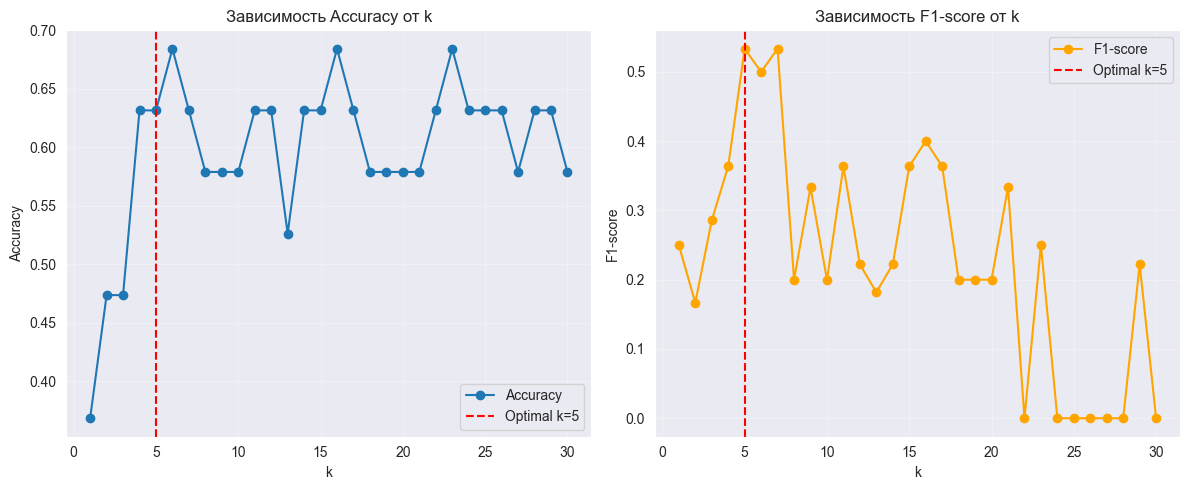

In [37]:
# график зависимости метрик от k
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_values, val_accuracies, marker='o', label='Accuracy')
plt.axvline(best_k, color='r', linestyle='--', label=f'Optimal k={best_k}')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Зависимость Accuracy от k')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(k_values, val_f1_scores, marker='o', color='orange', label='F1-score')
plt.axvline(best_k, color='r', linestyle='--', label=f'Optimal k={best_k}')
plt.xlabel('k')
plt.ylabel('F1-score')
plt.title('Зависимость F1-score от k')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [38]:
# обучаем модель с оптимальным k
knn_clf = KNNClassifier(k=best_k)
knn_clf.fit(X_train_scaled, y_train)
y_pred_knn = knn_clf.predict(X_test_scaled)
y_proba_knn = knn_clf.predict_proba(X_test_scaled)

print("="*60)
print("КЛАССИФИКАТОР k-БЛИЖАЙШИХ СОСЕДЕЙ")
print("="*60)
print(f"Оптимальное k: {best_k}")
print(f"\nРезультаты на тестовой выборке:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_knn):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_knn, zero_division=0):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_knn, zero_division=0):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_knn[:, 1]):.4f}")

КЛАССИФИКАТОР k-БЛИЖАЙШИХ СОСЕДЕЙ
Оптимальное k: 5

Результаты на тестовой выборке:
Accuracy: 0.6000
Precision: 0.5000
Recall: 0.5000
ROC-AUC: 0.6406


# Модель 3 - Логистическая регрессия (реализация)

In [39]:
class LogisticRegression:
    """Логистическая регрессия с градиентным спуском"""

    def __init__(self, learning_rate=0.01, n_iterations=1000, regularization=0.01):
        self.lr = learning_rate
        self.n_iterations = n_iterations
        self.regularization = regularization
        self.weights = None
        self.bias = None
        self.losses = []

    def _sigmoid(self, z):
        """Сигмоидная функция"""
        return 1 / (1 + np.exp(-np.clip(z, -500, 500)))  # clipping для численной стабильности

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Инициализация параметров
        self.weights = np.zeros(n_features)
        self.bias = 0

        # Градиентный спуск
        for i in range(self.n_iterations):
            # Прямое распространение
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self._sigmoid(linear_model)

            # Вычисление градиентов
            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y)) + (self.regularization / n_samples) * self.weights
            db = (1 / n_samples) * np.sum(y_predicted - y)

            # Обновление параметров
            self.weights -= self.lr * dw
            self.bias -= self.lr * db

            # Вычисление loss (для отслеживания)
            if i % 100 == 0:
                loss = -np.mean(y * np.log(y_predicted + 1e-9) + (1 - y) * np.log(1 - y_predicted + 1e-9))
                self.losses.append(loss)

        return self

    def predict_proba(self, X):
        """Возвращает вероятности"""
        linear_model = np.dot(X, self.weights) + self.bias
        y_proba = self._sigmoid(linear_model)
        return np.vstack([1 - y_proba, y_proba]).T

    def predict(self, X, threshold=0.5):
        """Предсказывает класс с заданным порогом"""
        y_proba = self.predict_proba(X)[:, 1]
        return (y_proba >= threshold).astype(int)

# Обучаем модель
logreg = LogisticRegression(learning_rate=0.1, n_iterations=2000, regularization=0.1)
logreg.fit(X_train_scaled, y_train)

print("="*60)
print("ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ")
print("="*60)
print(f"Параметры модели обучены")
print(f"Количество признаков: {len(logreg.weights)}")

ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ
Параметры модели обучены
Количество признаков: 9


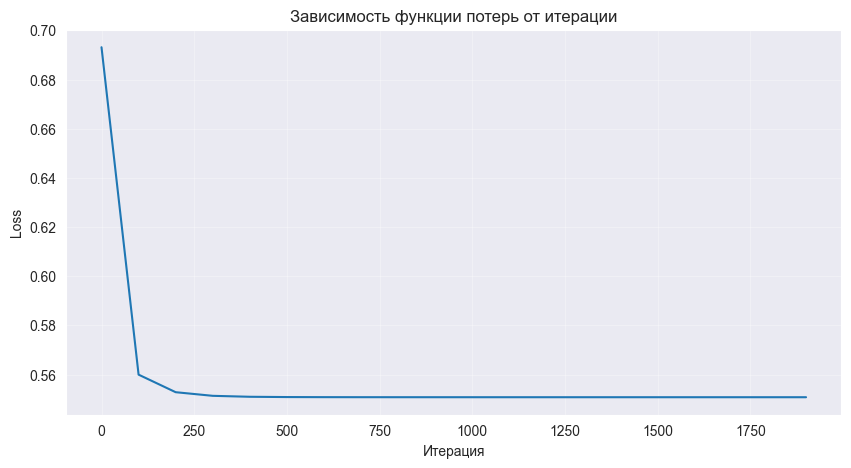

In [40]:
# график функции потерь
plt.figure(figsize=(10, 5))
plt.plot(range(0, len(logreg.losses) * 100, 100), logreg.losses)
plt.xlabel('Итерация')
plt.ylabel('Loss')
plt.title('Зависимость функции потерь от итерации')
plt.grid(True, alpha=0.3)
plt.show()

In [41]:
# подбор порога классификации
thresholds = np.linspace(0, 1, 101)
val_precisions = []
val_recalls = []
val_f1s = []

y_proba_val = logreg.predict_proba(X_val_scaled)[:, 1]

for threshold in thresholds:
    y_pred_val = (y_proba_val >= threshold).astype(int)

    prec = precision_score(y_val, y_pred_val, zero_division=0)
    rec = recall_score(y_val, y_pred_val, zero_division=0)
    f1 = 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0

    val_precisions.append(prec)
    val_recalls.append(rec)
    val_f1s.append(f1)

# оптимальный порог
best_threshold = thresholds[np.argmax(val_f1s)]
best_f1 = max(val_f1s)

print(f"Оптимальный порог классификации: {best_threshold:.3f}")
print(f"F1-score на валидации: {best_f1:.4f}")

Оптимальный порог классификации: 0.160
F1-score на валидации: 0.6087


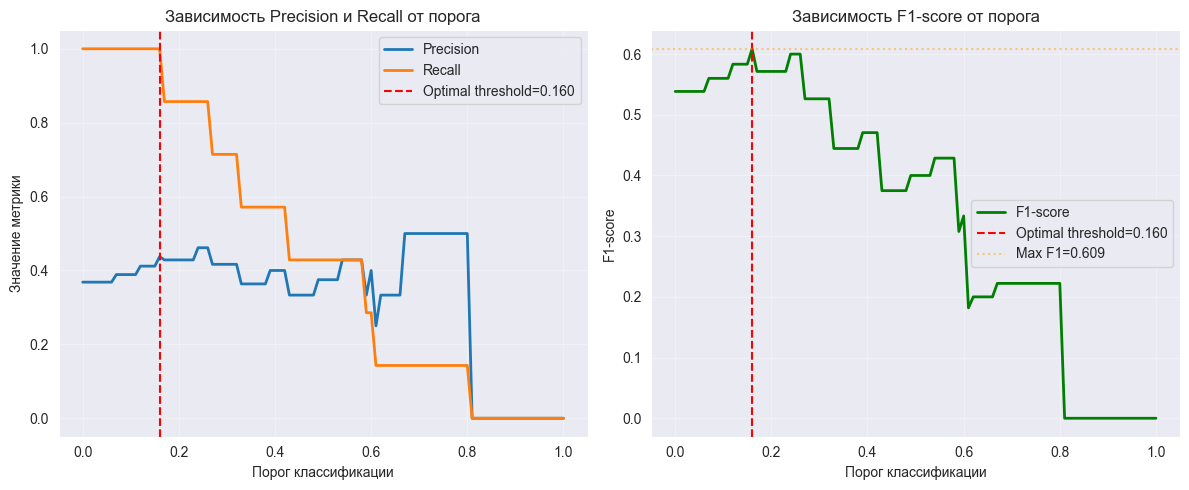

In [42]:
# график зависимости метрик от порога
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(thresholds, val_precisions, label='Precision', linewidth=2)
plt.plot(thresholds, val_recalls, label='Recall', linewidth=2)
plt.axvline(best_threshold, color='r', linestyle='--', label=f'Optimal threshold={best_threshold:.3f}')
plt.xlabel('Порог классификации')
plt.ylabel('Значение метрики')
plt.title('Зависимость Precision и Recall от порога')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(thresholds, val_f1s, label='F1-score', color='green', linewidth=2)
plt.axvline(best_threshold, color='r', linestyle='--', label=f'Optimal threshold={best_threshold:.3f}')
plt.axhline(best_f1, color='orange', linestyle=':', alpha=0.5, label=f'Max F1={best_f1:.3f}')
plt.xlabel('Порог классификации')
plt.ylabel('F1-score')
plt.title('Зависимость F1-score от порога')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [43]:
# оцениваем на тестовой выборке с оптимальным порогом
y_pred_logreg = logreg.predict(X_test_scaled, threshold=best_threshold)
y_proba_logreg = logreg.predict_proba(X_test_scaled)

print("="*60)
print("ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ (с оптимальным порогом)")
print("="*60)
print(f"Оптимальный порог: {best_threshold:.3f}")
print(f"\nРезультаты на тестовой выборке:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_logreg):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_logreg, zero_division=0):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_logreg, zero_division=0):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_logreg[:, 1]):.4f}")

ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ (с оптимальным порогом)
Оптимальный порог: 0.160

Результаты на тестовой выборке:
Accuracy: 0.6500
Precision: 0.5385
Recall: 0.8750
ROC-AUC: 0.6875


# Сравнительная таблица всех моделей

In [44]:
results = {
    'Модель': [
        'Тривиальный классификатор',
        'Наивный Байес',
        'k-NN',
        'Логистическая регрессия'
    ],
    'Accuracy': [
        accuracy_score(y_test, y_pred_trivial),
        accuracy_score(y_test, y_pred_nb),
        accuracy_score(y_test, y_pred_knn),
        accuracy_score(y_test, y_pred_logreg)
    ],
    'Precision': [
        precision_score(y_test, y_pred_trivial, zero_division=0),
        precision_score(y_test, y_pred_nb, zero_division=0),
        precision_score(y_test, y_pred_knn, zero_division=0),
        precision_score(y_test, y_pred_logreg, zero_division=0)
    ],
    'Recall': [
        recall_score(y_test, y_pred_trivial, zero_division=0),
        recall_score(y_test, y_pred_nb, zero_division=0),
        recall_score(y_test, y_pred_knn, zero_division=0),
        recall_score(y_test, y_pred_logreg, zero_division=0)
    ],
    'ROC-AUC': [
        roc_auc_score(y_test, y_proba_trivial[:, 1]) if len(np.unique(y_pred_trivial)) > 1 else 0.5,
        roc_auc_score(y_test, y_proba_nb[:, 1]),
        roc_auc_score(y_test, y_proba_knn[:, 1]),
        roc_auc_score(y_test, y_proba_logreg[:, 1])
    ]
}

results_df = pd.DataFrame(results)
results_df['F1-score'] = 2 * (results_df['Precision'] * results_df['Recall']) / (results_df['Precision'] + results_df['Recall'])
results_df['F1-score'].fillna(0, inplace=True)

print("="*80)
print("СРАВНЕНИЕ МОДЕЛЕЙ НА ТЕСТОВОЙ ВЫБОРКЕ")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)

# Находим лучшую модель
best_model_idx = results_df['ROC-AUC'].idxmax()
print(f"\nЛучшая модель по ROC-AUC: {results_df.loc[best_model_idx, 'Модель']}")
print(f"ROC-AUC: {results_df.loc[best_model_idx, 'ROC-AUC']:.4f}")

СРАВНЕНИЕ МОДЕЛЕЙ НА ТЕСТОВОЙ ВЫБОРКЕ
                   Модель  Accuracy  Precision  Recall  ROC-AUC  F1-score
Тривиальный классификатор      0.60   0.000000   0.000 0.500000  0.000000
            Наивный Байес      0.45   0.333333   0.375 0.489583  0.352941
                     k-NN      0.60   0.500000   0.500 0.640625  0.500000
  Логистическая регрессия      0.65   0.538462   0.875 0.687500  0.666667

Лучшая модель по ROC-AUC: Логистическая регрессия
ROC-AUC: 0.6875


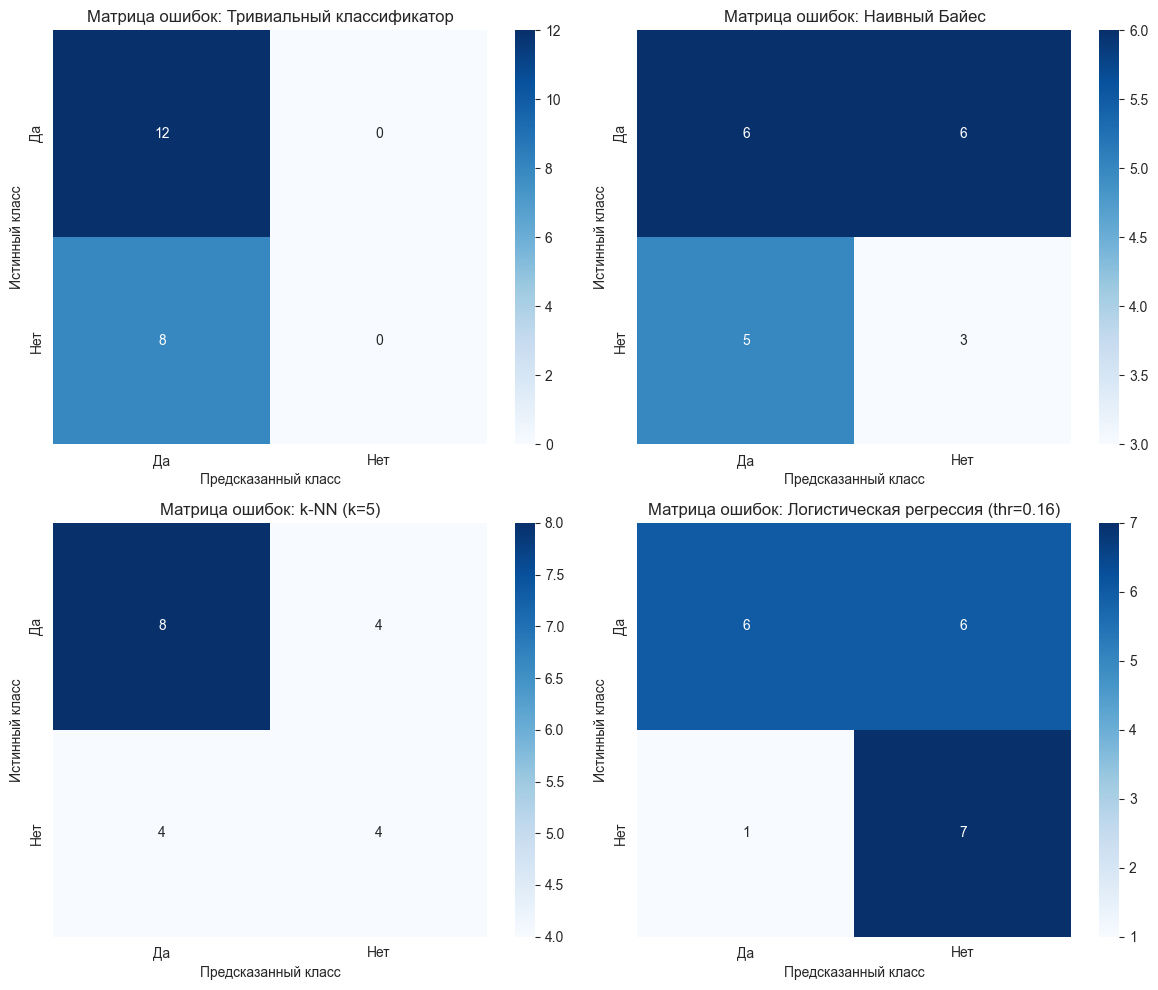

МАТРИЦЫ ОШИБОК

Тривиальный классификатор:
  TN=12, FP=0
  FN=8, TP=0

Наивный Байес:
  TN=6, FP=6
  FN=5, TP=3

k-NN (k=5):
  TN=8, FP=4
  FN=4, TP=4

Логистическая регрессия (thr=0.16):
  TN=6, FP=6
  FN=1, TP=7


In [45]:
# Матрицы ошибок для всех моделей

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

predictions = [
    (y_pred_trivial, 'Тривиальный классификатор'),
    (y_pred_nb, 'Наивный Байес'),
    (y_pred_knn, f'k-NN (k={best_k})'),
    (y_pred_logreg, f'Логистическая регрессия (thr={best_threshold:.2f})')
]

for idx, (y_pred, title) in enumerate(predictions):
    ax = axes[idx // 2, idx % 2]
    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=le_target.classes_,
                yticklabels=le_target.classes_)
    ax.set_xlabel('Предсказанный класс')
    ax.set_ylabel('Истинный класс')
    ax.set_title(f'Матрица ошибок: {title}')

plt.tight_layout()
plt.show()

# Выводим матрицы ошибок в текстовом виде
print("="*60)
print("МАТРИЦЫ ОШИБОК")
print("="*60)
for y_pred, title in predictions:
    cm = confusion_matrix(y_test, y_pred)
    print(f"\n{title}:")
    print(f"  TN={cm[0,0]}, FP={cm[0,1]}")
    print(f"  FN={cm[1,0]}, TP={cm[1,1]}")